# Datasets & DataLoaders
处理数据样本的代码可能会变得杂乱无章且难以维护；理想情况下，为了更好的可读性和模块化，我们希望数据集代码与模型训练代码解耦。PyTorch 提供了两个数据原语(data primitives)：`torch.utils.data.DataLoader` 和 `torch.utils.data.Dataset`，它们允许你使用预加载的数据集以及你自己的数据。
- `Dataset` 存储样本及其相应的标签，
- `DataLoader` 在 Dataset 周围包装一个可迭代对象，以便轻松访问样本。
PyTorch 领域库提供了许多预加载的数据集（如 FashionMNIST），这些数据集继承自 `torch.utils.data.Dataset` 类，并实现了特定于该数据的函数。它们可用于对模型进行原型设计和基准测试。你可以在这里找到它们：[图像数据集](https://docs.pytorch.org/vision/stable/datasets.html)、[文本数据集](https://docs.pytorch.org/text/stable/datasets.html)和[音频数据集](https://docs.pytorch.org/audio/stable/datasets.html)。

## Loading a Dataset
以下是一个如何从 TorchVision 加载 [Fashion-MNIST](https://github.com/zalandoresearch/) 数据集的示例。[Fashion-MNIST](https://github.com/zalandoresearch/) 是一个由 Zalando 的商品图片组成的数据集，包含 60000 个训练样本和 10000 个测试样本。每个样本由一张 28×28 的灰度图像和一个来自 10 个类别之一的关联标签组成。
我们使用以下参数加载 [FashionMNIST Dataset](https://docs.pytorch.org/vision/stable/datasets.html#fashion-mnist)：
- `root` 是存储训练 / 测试数据的路径，
- `train` 指定训练数据集或测试数据集，
- `download=True` 表示如果数据在 root 路径下不可用，则从互联网下载数据。
- `transform` 和 `target_transform` 指定特征和标签转换

In [3]:
# 导入PyTorch库，用于深度学习任务
import torch

# 从torch.utils.data模块导入Dataset类，用于自定义数据集
from torch.utils.data import Dataset

# 从torchvision导入datasets模块，提供常见数据集加载功能
from torchvision import datasets

# 导入ToTensor变换，用于将PIL图像或numpy数组转换为torch张量
from torchvision.transforms import ToTensor

# 导入matplotlib.pyplot，用于数据可视化
import matplotlib.pyplot as plt

# 加载FashionMNIST训练数据集
training_data = datasets.FashionMNIST(
    root="/home/yilin/TRAE/data",             # 数据存储路径
    train=True,              # 指定加载训练集
    download=True,           # 若数据不存在则自动下载
    transform=ToTensor()     # 应用ToTensor变换
)

# 加载FashionMNIST测试数据集
test_data = datasets.FashionMNIST(
    root="/home/yilin/TRAE/data",             # 数据存储路径（与训练集一致）
    train=False,             # 指定加载测试集
    download=True,           # 若数据不存在则自动下载
    transform=ToTensor()     # 应用ToTensor变换
)

## Iterating and Visualizing the Dataset (迭代和可视化数据集)
我们可以像操作列表一样手动对数据集进行索引：`training_data [index]`。我们使用 `matplotlib` 来可视化训练数据中的一些样本。

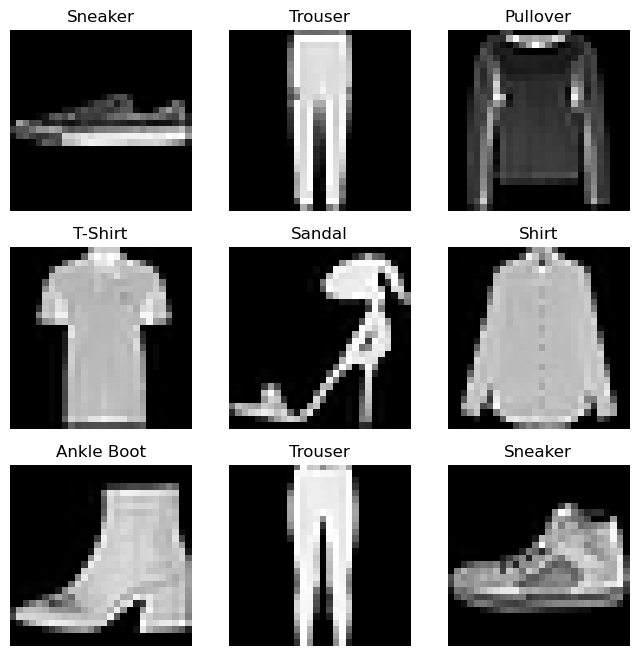

In [6]:
# 定义标签映射字典：将数字标签(0-9)映射为对应的时尚物品类别名称
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

# 创建一个8x8英寸的图像显示窗口
figure = plt.figure(figsize=(8, 8))

# 设置子图排列为3行3列(共9个子图)
cols, rows = 3, 3

# 循环生成9个子图，显示随机选择的训练样本
for i in range(1, cols * rows + 1):
    # 随机选择一个训练样本的索引
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    
    # 从训练数据中获取图像和对应的标签
    img, label = training_data[sample_idx]
    
    # 在3x3网格的第i个位置添加子图
    figure.add_subplot(rows, cols, i)
    
    # 设置子图标题为标签对应的服装类别名称
    plt.title(labels_map[label])
    
    # 关闭坐标轴显示，使图像更简洁
    plt.axis("off")
    
    # 显示图像，squeeze()用于移除单维度(如灰度图像的通道维度)
    plt.imshow(img.squeeze(), cmap="gray")

# 显示包含所有子图的完整图像
plt.show()

## Creating a Custom Dataset for your files 为你的文件创建自定义数据集
- 自定义数据集类必须实现三个函数：`init`、`len` 和 `getitem`。
- 看一下这个实现；FashionMNIST 图像存储在 `img_dir` 目录中，它们的标签则单独存储在一个 **CSV** 文件 `annotations_file` 中。
- 在接下来的章节中，我们将详细分析这些函数中各自发生了什么。

In [8]:
import os                       # 用于路径操作和文件处理
import pandas as pd             # 用于读取CSV注释文件
from torchvision.io import decode_image  # 用于解码图像文件

class CustomImageDataset(Dataset):
    """自定义图像数据集类，继承自PyTorch的Dataset基类"""
    
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        """
        初始化数据集
        
        参数:
            annotations_file: 包含图像文件名和对应标签的CSV文件路径
            img_dir: 图像文件所在目录
            transform: 图像预处理转换函数
            target_transform: 标签预处理转换函数
        """
        # 读取CSV文件，DataFrame格式存储图像文件名和标签
        self.img_labels = pd.read_csv(annotations_file)
        
        # 保存图像文件所在目录路径
        self.img_dir = img_dir
        
        # 保存图像转换函数(用于数据增强、归一化等)
        self.transform = transform
        
        # 保存标签转换函数(如标签编码转换)
        self.target_transform = target_transform

    def __len__(self):
        """返回数据集的总样本数"""
        return len(self.img_labels)  # 返回CSV文件的行数

    def __getitem__(self, idx):
        """
        获取指定索引的样本
        
        参数:
            idx: 样本索引(0到len(self)-1)
            
        返回:
            image: 处理后的图像张量
            label: 对应的标签
        """
        # 构建完整图像路径: 目录路径 + CSV中记录的文件名(第一列)
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        
        # 读取并解码图像文件
        image = decode_image(img_path)  
        
        # 从CSV中获取对应标签(通常为第二列)
        label = self.img_labels.iloc[idx, 1]
        
        # 应用图像转换(如果有定义)
        if self.transform:
            image = self.transform(image)
            
        # 应用标签转换(如果有定义)
        if self.target_transform:
            label = self.target_transform(label)
            
        # 返回处理后的图像和标签
        return image, label

#### `__init__`
- `__init__`函数在实例化 **Dataset** 对象时运行一次。我们初始化包含图像的目录、注释文件以及两种变换（下一节将更详细介绍）
- The labels.csv file looks like:
    ```bash
    tshirt1.jpg, 0
    tshirt2.jpg, 0
    ......
    ankleboot999.jpg, 9
    ```
    ```python
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
    ```


#### `__len__`
- `__len__`函数返回我们数据集中样本的数量。
- Example:
    ```python
    def __len__(self):
        return len(self.img_labels)
    ```


#### `__getitem__`
- `__getitem__` 函数根据给定的索引 idx 从数据集中加载并返回一个样本。基于该索引，它确定图像在磁盘上的位置.
- 使用 `decode_image` 将其转换为张量，从 `self.img_labels` 中的 csv 数据中检索相应的标签，对它们调用变换函数（如果适用），并以元组形式返回张量图像和相应的标签
- Example:
    ```python
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
    ```


## Preparing your data for training with DataLoaders (准备使用 DataLoaders 进行训练的数据)
- Dataset每次检索一个样本的数据集特征和标签。
- 在训练模型时，我们通常希望以 “小批量(minibatches)” 方式传递样本，在每个训练周期对数据进行重新洗牌以减少模型过拟合，并使用 Python 的`multiprocessing`处理来加快数据检索速度。
- `DataLoader` 是一个可迭代对象，它通过简单的 API 为我们抽象了这种复杂性

In [9]:
from torch.utils.data import DataLoader  # 导入PyTorch的数据加载器类，用于批量处理数据

# 创建训练数据加载器
train_dataloader = DataLoader(
    training_data,           # 传入训练数据集(如前面定义的CustomImageDataset实例)
    batch_size=64,           # 每个批次包含64个样本，控制内存使用和训练速度
    shuffle=True             # 每个训练周期前打乱数据顺序，增加训练随机性
)

# 创建测试数据加载器
test_dataloader = DataLoader(
    test_data,               # 传入测试数据集
    batch_size=64,           # 测试批次大小，通常与训练批次相同
    shuffle=True             # 测试阶段也打乱数据(可选)，某些情况下需要保持固定顺序
)

## Iterate through the DataLoader (遍历数据加载器)
- 我们已经将该数据集加载到数据加载器`DataLoader`中，并可以根据需要遍历数据集。
- 下面的每次迭代都会返回一批训练特征和训练标签（分别包含 `batch_size=64` 个特征和标签）。
- 由于我们指定了 `shuffle=True`，在遍历完所有批次后，数据会被打乱（如需对数据加载顺序进行更精细的控制，可以查看采样器 [Samplers](https://docs.pytorch.org/docs/stable/data.html#data-loading-order-and-sampler)）。

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


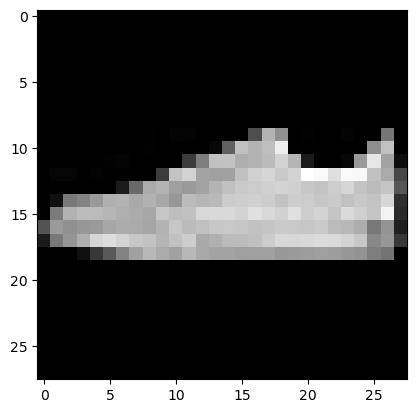

Label: 7


In [13]:
# Display image and label.

# 从训练数据加载器中获取一个批次的样本和标签
train_features, train_labels = next(iter(train_dataloader))

# 打印样本批次的形状信息（通常为[批次大小, 通道数, 高度, 宽度]）
print(f"Feature batch shape: {train_features.size()}")

# 打印标签批次的形状信息（通常为[批次大小]）
print(f"Labels batch shape: {train_labels.size()}")

# 提取批次中第一个样本并移除单维度条目（例如灰度图像的通道维度）
img = train_features[0].squeeze()

# 提取批次中第一个样本对应的标签
label = train_labels[0]

# 显示图像，使用灰度色彩映射
plt.imshow(img, cmap="gray")
# 显示图像
plt.show()

# 打印标签值（通常为类别索引或类别名称）
print(f"Label: {label}")